In [37]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from Utils import plot_decision_regions

# Incomplete data

In [2]:
# create a incomplete dataset
csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [3]:
# check if any feature is null for any sample
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [4]:
# one method is just remove any incomplete samples
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [5]:
# or remove the feature that is null for some samples
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [6]:
# can also remove certain sample when only it is null for certain feature
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


In [7]:
# another method is to impute the data, such as using mean of the feature (or can use median, most, etc)
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)                    # train imputer
imputed_data = imr.transform(df.values)     # transform incomplete dataset
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [8]:
# or just use pandas
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


# Categorical data

In [9]:
# create dataset with ordinal and nominal categorical features
df = pd.DataFrame([['green', 'M', 10.1, 'class2'], ['red', 'L', 13.5, 'class1'], ['blue', 'XL', 15.3, 'class2']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [10]:
# convert the ordinal feature into ordered numbers
size_mapping = {'XL': 3, 'L': 2, 'M': 1}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [11]:
# convert the categorical class label into numbers (sklearn also usually does this automatically)
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [12]:
# or use sklearn label encoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)  # does not transform the original df
y

array([1, 0, 1], dtype=int64)

In [13]:
# nominal categorical feature needs to be converted using one-hot encoding, so that the classifier do not assume there is any order
color_ohe = OneHotEncoder()

# creat the feature dataset
X = df[['color', 'size', 'price']].values
# only one-hot encode the color feature
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [14]:
# another method of one-hot encoding is using pandas
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


In [15]:
# a drawback of one-hot encoding is that it creates correlated features, which is an issue for certain methods such as matrix inversion
# to reduce correlation, we can remove one feature from the one-hot encoded, e.g. we don't need the blue feature since RG = 0 means B = 1
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)
# or use sklearn color_ohe = OneHotEncoder(categories='auto', drop='first')

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


# Feature Scaling

In [16]:
# read dataset
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol','Malic acid', 'Ash','Alcalinity of ash', 'Magnesium','Total phenols', 'Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline']

# check how many unique classes
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [17]:
# split into features and labels
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [18]:
# one method of scaling is normalization (min-max scaling)
mms = MinMaxScaler()
X_train_normalized = mms.fit_transform(X_train)
X_test_normalized = mms.transform(X_test)

In [19]:
# one method is standardization, which is more practical
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Feature Selection

In [20]:
# L1 regularization can be used to select features as it creates sparse feature vectors (that will have non-zero weights)
# lbfds doesn't support L1, so use liblinear
lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', multi_class='ovr')

lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


In [21]:
# L1 reguarlization created some zero weights, meaning those features were not used
lr.coef_

array([[ 1.2460333 ,  0.18062105,  0.74511971, -1.16287799,  0.        ,
         0.        ,  1.16447243,  0.        ,  0.        ,  0.        ,
         0.        ,  0.5525552 ,  2.50955646],
       [-1.53889326, -0.38580295, -0.99546388,  0.3637025 , -0.05924919,
         0.        ,  0.66679909,  0.        ,  0.        , -1.93130706,
         1.23793114,  0.        , -2.23322808],
       [ 0.13573406,  0.16843155,  0.35740353,  0.        ,  0.        ,
         0.        , -2.4373306 ,  0.        ,  0.        ,  1.56339657,
        -0.8188347 , -0.49305853,  0.        ]])

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


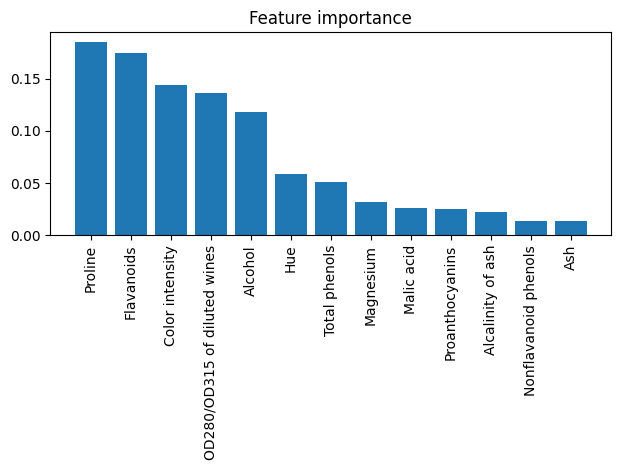

In [22]:
# random forest can also measure feature importance, so we can select
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)

# get the feature importance from training
importances = forest.feature_importances_
# sort the importance index
indices = np.argsort(importances)[::-1]

feature_labels = df_wine.columns[1:]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feature_labels[indices[f]], importances[indices[f]]))

# plot importance
plt.title('Feature importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feature_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [23]:
# can then select features based on the random forest feature importance
sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feature_labels[indices[f]], importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529


# Feature Extraction (PCA)

In [24]:
# PCA can be used as a unsupervised algorithm to extract features and reduce dimension

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [25]:
# 1st step of PCA is to standardize data

# split into train and test
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# standardize data
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [26]:
# 2nd step is to construct covariance matrix, and get eigenvectors and eigenvalues (one per feature in the original dataset)
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n', eigen_vals)


Eigenvalues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


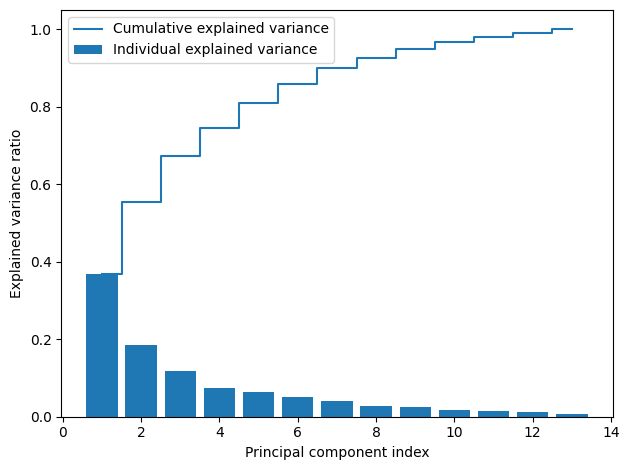

In [27]:
# variance explained ratios, shows how important each eigenvector is
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)] # sort eigenvalues in decreasing order
# vector of cumulative sum of eigenvalues (add up to 1)
cumulative_var_exp = np.cumsum(var_exp)

# plot to see how important each eigenvector is, to help us select the new dimension of eigenvectors
plt.bar(range(1,14), var_exp, align='center', label='Individual explained variance')
plt.step(range(1,14), cumulative_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [28]:
# next is to construct a projection matrix from the k-most important eigenvectors

# create a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
# sort in decreasing order of eigenvalue
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# select the 2 most eigenvectors for the projection matrix
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Projection Matrix:\n', w)

Projection Matrix:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


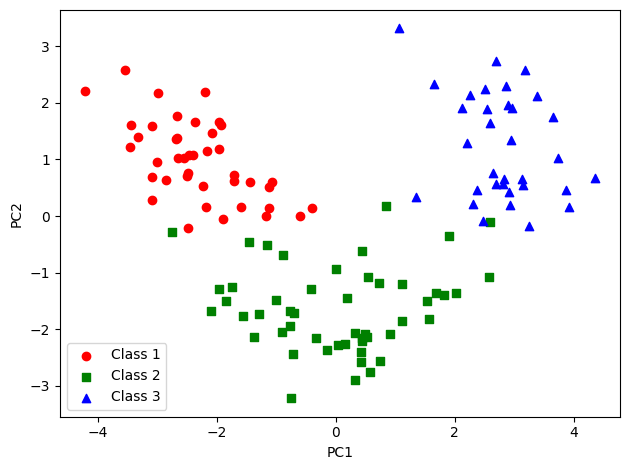

In [29]:
# transform the original feature space into the new feature space
X_train_pca = X_train_std.dot(w)

# plot the new dataset (now only 2 features)
colors = ['r', 'g', 'b']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], X_train_pca[y_train==l, 1], c=c, label=f'Class {l}', marker=m)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

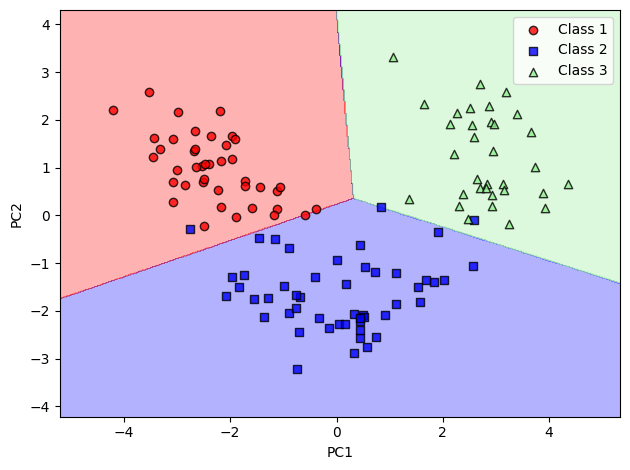

In [30]:
# or use sklearn
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# train on the reduced dataset
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr.fit(X_train_pca, y_train)

plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

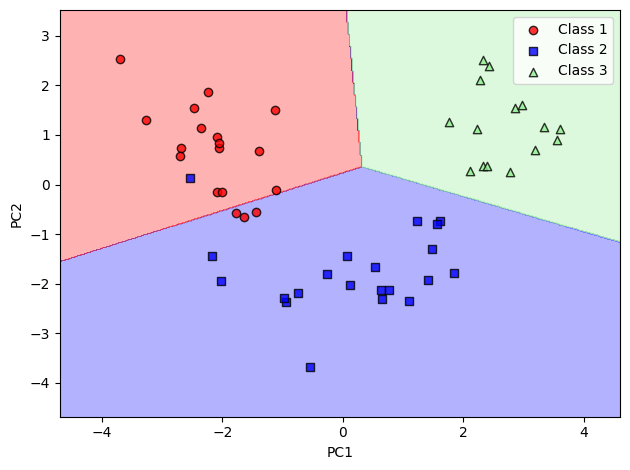

In [31]:
# plot test set too
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [32]:
# can also get the explained ratio to see the importance order of eigenvectors, by setting n_components as none
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

# Feature Extraction (LDA)

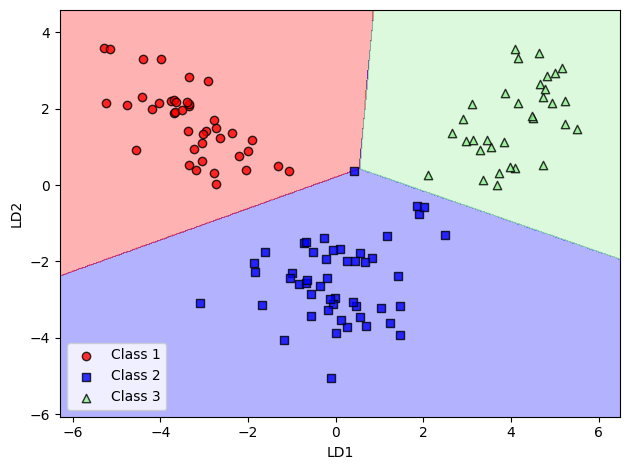

In [33]:
# LDA is a supervised algorithm
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)  # lda is supervised, need class label
X_test_lda = lda.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

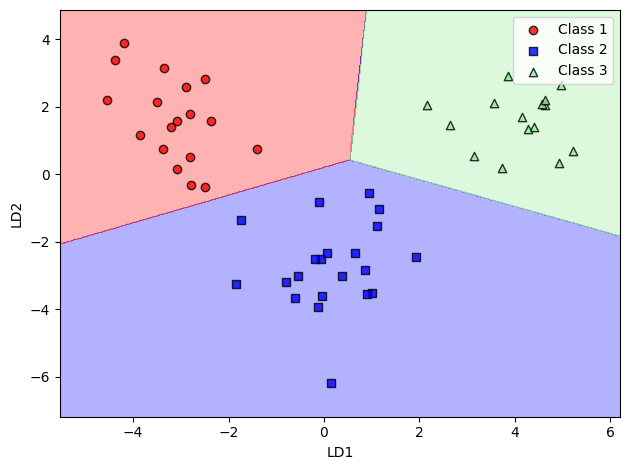

In [34]:
# check test set
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Nonlinear Dimensionality Reduction (t-SNE)

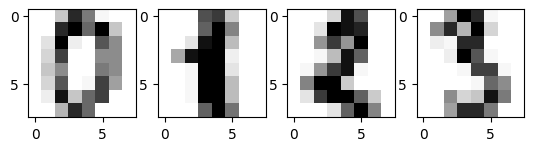

In [35]:
# both PCA and LDA are linear algorithm
# t-SNE is nonlinear and is popular for visualizing high-demension data in 2D or 3D

# load digits data, 8x8 pixel image = 64 features
digits = load_digits()
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(digits.images[i], cmap='Greys')
plt.show()

In [36]:
y_digits = digits.target
X_digits = digits.data

# transform using t-SNE
tsne = TSNE(n_components=2, init='pca', random_state=123)
X_digits_tsne = tsne.fit_transform(X_digits)

e:\Python\Python39\venv\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
e:\Python\Python39\venv\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


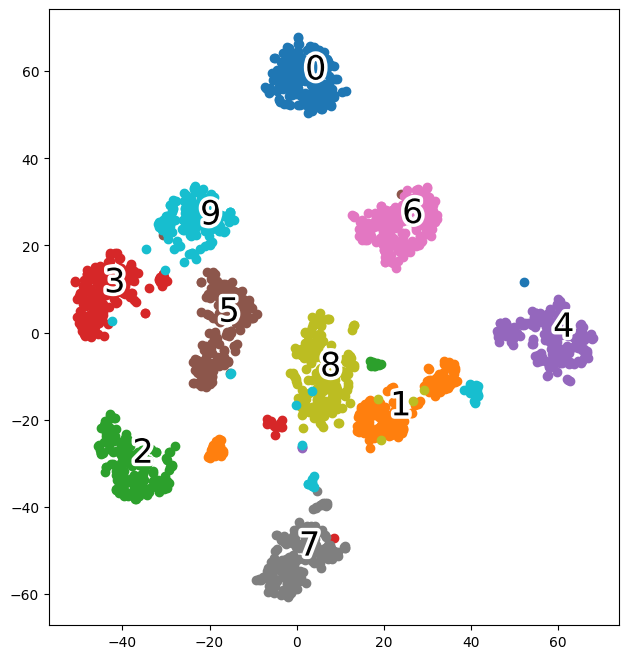

In [39]:
def plot_projection(x, y):
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    for i in range(10):
        plt.scatter(x[y == i, 0], x[y == i, 1])
    for i in range(10):
        xtext, ytext = np.median(x[y == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])

# plot t-SNE transformed number image data in 2D
plot_projection(X_digits_tsne, y_digits)
plt.show()